In [1]:
import spacy
nlp = spacy.blank('id')
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
import re
import string
nltk.download('punkt')

komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [7]:
from MeanVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [8]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [12]:
weights = y_train_enc
weights = np.choose(weights, [0.94, 1.1, 1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [0.94 0.94 1.1  ... 1.1  1.   1.  ] 

Ini y_train_encode
 [0 0 1 ... 1 2 2] 



In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000
    
param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

# param['num_class']=len(set(y))
# param['learning_rate'] = 0.001
# param['max_depth'] = 7
# param['min_child_weight'] = 10
# param['gamma'] = 2
# param['reg_alpha'] = 0.9
# param['reg_lambda'] = 4
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['objective'] = 'multi:softmax'
# param['scale_pos_weight'] = 1

watchlist = [(train, 'train'), (test, 'test')]
# num_round = 100
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.35807	test-merror:0.54735
[1]	train-merror:0.27531	test-merror:0.49599
[2]	train-merror:0.22716	test-merror:0.46870
[3]	train-merror:0.20016	test-merror:0.43339
[4]	train-merror:0.17988	test-merror:0.44944
[5]	train-merror:0.15998	test-merror:0.43660
[6]	train-merror:0.15679	test-merror:0.42376
[7]	train-merror:0.14978	test-merror:0.42215
[8]	train-merror:0.14424	test-merror:0.39807
[9]	train-merror:0.13512	test-merror:0.41091
[10]	train-merror:0.14141	test-merror:0.40770
[11]	train-merror:0.13180	test-merror:0.40770
[12]	train-merror:0.13013	test-merror:0.40449
[13]	train-merror:0.12608	test-merror:0.40289
[14]	train-merror:0.12294	test-merror:0.41252
[15]	train-merror:0.11608	test-merror:0.41091
[16]	train-merror:0.11668	test-merror:0.39647
[17]	train-merror:0.11616	test-merror:0.39647
[18]	train-merror:0.11177	test-merror:0.40128
[19]	train-merror:0.11124	test-merror:0.39807
[20]	train-merror:0.10616	test-merror:0.41573
[21]	train-merror:0.10657	test-merror:0.4077

[177]	train-merror:0.03676	test-merror:0.34992
[178]	train-merror:0.03553	test-merror:0.35313
[179]	train-merror:0.03470	test-merror:0.35313
[180]	train-merror:0.03470	test-merror:0.35313
[181]	train-merror:0.03383	test-merror:0.35313
[182]	train-merror:0.03506	test-merror:0.35474
[183]	train-merror:0.03386	test-merror:0.35634
[184]	train-merror:0.03386	test-merror:0.35634
[185]	train-merror:0.03422	test-merror:0.35795
[186]	train-merror:0.03422	test-merror:0.35634
[187]	train-merror:0.03383	test-merror:0.35313
[188]	train-merror:0.03345	test-merror:0.35474
[189]	train-merror:0.03263	test-merror:0.35152
[190]	train-merror:0.03343	test-merror:0.35152
[191]	train-merror:0.03339	test-merror:0.34831
[192]	train-merror:0.03218	test-merror:0.34831
[193]	train-merror:0.03225	test-merror:0.35152
[194]	train-merror:0.03182	test-merror:0.35313
[195]	train-merror:0.03066	test-merror:0.35313
[196]	train-merror:0.03109	test-merror:0.35152
[197]	train-merror:0.03070	test-merror:0.35152
[198]	train-m

[352]	train-merror:0.00881	test-merror:0.34350
[353]	train-merror:0.00841	test-merror:0.34510
[354]	train-merror:0.00804	test-merror:0.34350
[355]	train-merror:0.00881	test-merror:0.34189
[356]	train-merror:0.00841	test-merror:0.34189
[357]	train-merror:0.00841	test-merror:0.34189
[358]	train-merror:0.00801	test-merror:0.34350
[359]	train-merror:0.00801	test-merror:0.34189
[360]	train-merror:0.00801	test-merror:0.34350
[361]	train-merror:0.00801	test-merror:0.34350
[362]	train-merror:0.00801	test-merror:0.34671
[363]	train-merror:0.00764	test-merror:0.34350
[364]	train-merror:0.00764	test-merror:0.34350
[365]	train-merror:0.00724	test-merror:0.34350
[366]	train-merror:0.00762	test-merror:0.34350
[367]	train-merror:0.00801	test-merror:0.34029
[368]	train-merror:0.00762	test-merror:0.34350
[369]	train-merror:0.00764	test-merror:0.34189
[370]	train-merror:0.00724	test-merror:0.34189
[371]	train-merror:0.00764	test-merror:0.34189
[372]	train-merror:0.00724	test-merror:0.34510
[373]	train-m

[527]	train-merror:0.00399	test-merror:0.33547
[528]	train-merror:0.00399	test-merror:0.33547
[529]	train-merror:0.00360	test-merror:0.33547
[530]	train-merror:0.00360	test-merror:0.33708
[531]	train-merror:0.00360	test-merror:0.33708
[532]	train-merror:0.00360	test-merror:0.33708
[533]	train-merror:0.00316	test-merror:0.33868
[534]	train-merror:0.00360	test-merror:0.33868
[535]	train-merror:0.00360	test-merror:0.33868
[536]	train-merror:0.00360	test-merror:0.33868
[537]	train-merror:0.00399	test-merror:0.33708
[538]	train-merror:0.00360	test-merror:0.33547
[539]	train-merror:0.00360	test-merror:0.33708
[540]	train-merror:0.00360	test-merror:0.33708
[541]	train-merror:0.00316	test-merror:0.33708
[542]	train-merror:0.00356	test-merror:0.33708
[543]	train-merror:0.00356	test-merror:0.33708
[544]	train-merror:0.00356	test-merror:0.33708
[545]	train-merror:0.00356	test-merror:0.33708
[546]	train-merror:0.00316	test-merror:0.33708
[547]	train-merror:0.00316	test-merror:0.33708
[548]	train-m

[702]	train-merror:0.00154	test-merror:0.33387
[703]	train-merror:0.00154	test-merror:0.33547
[704]	train-merror:0.00154	test-merror:0.33387
[705]	train-merror:0.00154	test-merror:0.33066
[706]	train-merror:0.00154	test-merror:0.32905
[707]	train-merror:0.00154	test-merror:0.33226
[708]	train-merror:0.00154	test-merror:0.33387
[709]	train-merror:0.00154	test-merror:0.33226
[710]	train-merror:0.00154	test-merror:0.33066
[711]	train-merror:0.00154	test-merror:0.33066
[712]	train-merror:0.00154	test-merror:0.33387
[713]	train-merror:0.00154	test-merror:0.33226
[714]	train-merror:0.00154	test-merror:0.33387
[715]	train-merror:0.00154	test-merror:0.33066
[716]	train-merror:0.00154	test-merror:0.33066
[717]	train-merror:0.00154	test-merror:0.33226
[718]	train-merror:0.00154	test-merror:0.33226
[719]	train-merror:0.00154	test-merror:0.33066
[720]	train-merror:0.00154	test-merror:0.33066
[721]	train-merror:0.00154	test-merror:0.33226
[722]	train-merror:0.00154	test-merror:0.33066
[723]	train-m

[877]	train-merror:0.00037	test-merror:0.33066
[878]	train-merror:0.00037	test-merror:0.33066
[879]	train-merror:0.00037	test-merror:0.33226
[880]	train-merror:0.00037	test-merror:0.33066
[881]	train-merror:0.00037	test-merror:0.33066
[882]	train-merror:0.00037	test-merror:0.33226
[883]	train-merror:0.00037	test-merror:0.33387
[884]	train-merror:0.00037	test-merror:0.33387
[885]	train-merror:0.00037	test-merror:0.33387
[886]	train-merror:0.00037	test-merror:0.33387
[887]	train-merror:0.00037	test-merror:0.33387
[888]	train-merror:0.00037	test-merror:0.33226
[889]	train-merror:0.00037	test-merror:0.33226
[890]	train-merror:0.00037	test-merror:0.33226
[891]	train-merror:0.00037	test-merror:0.33226
[892]	train-merror:0.00037	test-merror:0.33226
[893]	train-merror:0.00037	test-merror:0.33226
[894]	train-merror:0.00037	test-merror:0.33066
[895]	train-merror:0.00037	test-merror:0.33226
[896]	train-merror:0.00037	test-merror:0.33387
[897]	train-merror:0.00037	test-merror:0.33226
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6709470304975923 

Train Score
 0.9995987158908507 

CONFUSSION MATRIX
 [[172  37  11]
 [ 38 117  45]
 [ 24  50 129]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.74      0.78      0.76       220
      netral       0.57      0.58      0.58       200
     positif       0.70      0.64      0.66       203

    accuracy                           0.67       623
   macro avg       0.67      0.67      0.67       623
weighted avg       0.67      0.67      0.67       623
 



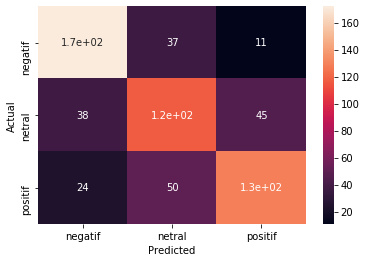

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])